In [1]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
me.init_vprinting()

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_interactions import ipyplot as iplt

import control as ct
from control.matlab import *
import scipy.linalg

# %%
# Specify the equations of motion
# -------------------------------
#
# The model is constructed using several constant parameters:
#
# - :math:`h`: distance mass center is from the ground contact line
# - :math:`a`: longitudinal distance of the mass center from the rear contact
# - :math:`b`: wheelbase length
# - :math:`g`: acceleration due to gravity
# - :math:`m`: mass of bicycle and rider
# - :math:`I_1`: roll principle moment of inertia
# - :math:`I_2`: pitch principle moment of inertia
# - :math:`I_3`: yaw principle moment of inertia
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3])
C_alpha = sm.Matrix([CaP, CaR])
r = sm.Matrix([q5, u5])
qd = q.diff(t)
qdd = qd.diff(t)

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p, CaP, CaR),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p, CaP, CaR), (alphaP, alphaR))


In [2]:
Md_slip = kane.mass_matrix_full[-4:, -4:] # extract the bottom 4 right side rows and columns because the top left is FK
# gd = kane.forcing_full[-4:] # extract the last 4 entries because they are gd # idk whty but this didnt work so I got each term and made a matrix
gd_slip = sm.Matrix([kane.forcing_full[4], kane.forcing_full[5], kane.forcing_full[6], kane.forcing_full[7]])
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)

u2d = {u1: q1.diff(t), u2:q2.diff(t), u3: q3.diff(t), u4: q4.diff(t)}
gd_slip = gd_slip.xreplace(u2d)
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)


EOM_slip = Md_slip * qdd + gd_slip

dq4, dq4dot = sm.symbols('delta_q4 delta_q4dot')

xe_repl = {
    q1 : 0,
    q2 : 0,
    q3 : 0,
    q4 : 0,
    q5 : 0,
    q1.diff(t) : 5*sm.cos(q3),
    q2.diff(t) : 5*sm.sin(q3),
    q3.diff(t) : 0,
    q4.diff(t) : 0,
    q5.diff(t) : 0,
    q1.diff(t).diff(t) : 0,
    q2.diff(t).diff(t) : 0,
    q3.diff(t).diff(t) : 0,
    q4.diff(t).diff(t) : 0,
    q5.diff(t).diff(t) : 0,
 }

x = sm.Matrix([
    q1,
    q2,
    q3,
    q4,
    q5,
    q1.diff(t),
    q2.diff(t),
    q3.diff(t),
    q4.diff(t),
    q5.diff(t),
    q1.diff(t).diff(t),
    q2.diff(t).diff(t),
    q3.diff(t).diff(t),
    q4.diff(t).diff(t),
    q5.diff(t).diff(t),
])

xe = sm.Matrix([
    0,
    0,
    0,
    0,
    0,
    5*sm.cos(q3),
    5*sm.sin(q3),
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
])


f_lin_slip = EOM_slip.subs(xe_repl) + EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe)
sm.trigsimp(f_lin_slip)

qdd_L = sm.Matrix([q1.diff(t).diff(t), q2.diff(t).diff(t), q3.diff(t).diff(t), q4.diff(t).diff(t)])
# Solve the system of equations for accelerationsI have more 
solutions = sm.solve(f_lin_slip, (qdd_L))
solutions
EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe), EOM_slip.subs(xe_repl), sm.trigsimp(f_lin_slip), solutions

########## Getting state space of my system #################

# Convert to equations
solutions_matrix = sm.Matrix([solutions[q] for q in qdd_L])

q1_ddot = solutions_matrix[0]
q2_ddot = solutions_matrix[1]
q3_ddot = solutions_matrix[2]
q4_ddot = solutions_matrix[3]

# State derivatives
state_derivative = sm.Matrix([q4.diff(t), q4_ddot]) # q3.diff(t), q3_ddot,

# Input vector
input_vector = sm.Matrix([q5])
x = sm.Matrix([q4, q4.diff(t)]) # where q5 is lean q3, q3.diff(t), 

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
A = state_derivative.jacobian(x)

# Compute B matrix: partial derivatives of state_derivative w.r.t. input
B = state_derivative.jacobian(input_vector)
B = -B

# Replace cos(q3) with 1 while preserving other cos terms
A = A.subs(sm.cos(q3), 1)
B = B.subs(sm.cos(q3), 1)

x0_lin = np.array([
    # 0.0,
    # 0.0,
    0.0,
    np.deg2rad(10.0),#lean
    # 4.0,# vel in
    0.0,
    0.0,
    # 0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    # 3600.0,  # CaP
    # 3600.0,  # CaR
])

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
eval_A = sm.lambdify((p, CaP, CaR), A)
eval_B = sm.lambdify((p, CaP, CaR), B)

A_val = eval_A(p_vals, 3600, 3600)
B_val = eval_B(p_vals, 3600, 3600)



In [3]:
# Define the cost matrices Q and R
Q = np.diag([200, 10])  # Penalty on states same size as A ( theta and theta dot)
R = np.diag([2])  # Penalize steering (input) effort same size as B (delta and delta_dot) and square, and numerically singular

# Step 4: Solve the continuous-time algebraic Riccati equation (CARE) to get the optimal gain matrix K
# P is the solution to the Riccati equation
P = scipy.linalg.solve_continuous_are(A_val, B_val, Q, R)
# the LQR gains matrix
K = np.linalg.inv(R) @ B_val.T @ P


In [4]:
def create_slip_monitor():
    """Track slip angles and detect anomalies"""
    monitor = {
        'last_alphaP': None,
        'last_alphaR': None,
        'slip_detected': False,
        'slip_start_times': [],
        'slip_end_times': [],
        'active_slip_periods': [],
        'slip_duration': 2.0
    }
    return monitor
# Initialize monitor
monitor = create_slip_monitor()


######################### LQR for asphault ##############################
theta_des = 0
import numpy as np
import scipy.linalg

# Define parameters for asphalt and ice
CaP_asphalt, CaR_asphalt = 3600.0, 3600.0  # High grip (asphalt)
CaP_ice, CaR_ice = 360.0, 360.0            # Low grip (ice)

# Compute controllers for both conditions
def compute_controllers(p):
    # Asphalt controller
    A_asphalt = eval_A(p, CaP_asphalt, CaR_asphalt)
    B_asphalt = eval_B(p, CaP_asphalt, CaR_asphalt)
    
    # Ice controller
    A_ice = eval_A(p, CaP_ice, CaR_ice)
    B_ice = eval_B(p, CaP_ice, CaR_ice)
    
    # Common cost matrices
    Q = np.diag([2500, 100])  # State penalty
    R = np.diag([2])          # Control penalty
    
    # Solve Riccati equations
    P_asphalt = scipy.linalg.solve_continuous_are(A_asphalt, B_asphalt, Q, R)
    P_ice = scipy.linalg.solve_continuous_are(A_ice, B_ice, Q, R)
    
    # Compute gain matrices
    K_asphalt = np.linalg.inv(R) @ B_asphalt.T @ P_asphalt
    K_ice = np.linalg.inv(R) @ B_ice.T @ P_ice
    
    return K_asphalt, K_ice

# Pre-compute both controllers
K_asphalt, K_ice = compute_controllers(p_vals)

def control(t, q, u):
    """
    Dual-mode LQR controller that automatically switches between
    asphalt and ice controllers based on time.
    """
    # Extract roll states
    theta = q[3]       # Roll angle (rad)
    theta_dot = u[3]    # Roll rate (rad/s)
    
    # Desired state
    x_des = np.array([np.deg2rad(theta_des), 0])
    x = np.array([theta, theta_dot])
    
    # Select controller based on time (15-19s = ice)
    if 15 <= t <= 19.0:
        K = K_ice
    else:
        K = K_asphalt
    
    # LQR feedback control
    delta = -K @ (x - x_des)
    
    return np.array([delta[0], 0.0])  # [steer_angle, steer_rate]


In [95]:
target_roll_angle = np.deg2rad(5.0)
initial_speed = 7.0  # m/s

# Create empty arrays to store slip angles and tire forces
alphaP_history = []
alphaR_history = []
FyP_history = []
FyR_history = []
time_history = []

control_history = []
control_times = []

def rhs(t, x, p):
    q = x[0:4]
    u = x[4:8]

    r = control(t, q, u)
    # r= [delta, 0] ### this make it end almost immediatly which is good 
    # Store control outputs with time stamps
    control_history.append(r)
    control_times.append(t)

     # Update CaP and CaR based on time
    if 15 <= t <= 19.0:
        CaP = 360.0  # for car on ice the value is normalized btwn 0.05 and 0.1 from the book on your PPT slide
        CaR = 360.0  # 
    else:
        CaP = 3600.0  # for a car the value is normalized between 0.8 and 1.0
        CaR = 3600.0  # 

 # Evaluate the equations of motion with the updated parameters
    M, F = eval_eom(q, u, r, p, CaP, CaR)

    # Evaluate slip angles
    alphaP_val, alphaR_val = eval_slip(q, u, r, p, CaP, CaR)
    # alphaR_val = -alphaR_val
    # # Process slip angles (detects and records large changes)
    # alphaP_clipped, alphaR_clipped = check_slips(t, alphaP, alphaR)

    alphaP_history.append(alphaP_val)
    alphaR_history.append(alphaR_val)

    # Cap slip angles at 6 degrees
    alpha_max = np.deg2rad(6.0)
    alphaP_val = np.clip(alphaP_val, -alpha_max, alpha_max)
    alphaR_val = np.clip(alphaR_val, -alpha_max, alpha_max)
    alphaR_val = alphaR_val 

    # Calculate tire forces
    time_history.append(t)
    FyP = CaP * alphaP_val
    FyR = CaR * alphaR_val
    FyP_history.append(FyP)
    FyR_history.append(FyR)


    return np.linalg.solve(M, F.squeeze())

x0 = np.array([
    0.0,
    0.0,
    0.0,
    target_roll_angle,  # q4 [rad]
    initial_speed,  # u1 [m/s]
    0.0,
    0.0,
    0.0,
])


def roll_angle_event(t, x, p):
    """
    Event function to stop the solver if roll angle (theta) exceeds 60 or goes below -60 degrees.
    """
    roll_angle = np.rad2deg(x[3])  # x[3] is the roll angle (theta), converted to degrees
    max_angle = 30  # Upper and lower bounds in degrees
    
    # Return the difference between the roll angle and the bounds
    # The event is triggered when this value crosses zero
    return roll_angle**2 - max_angle**2  # Returns 0 when |roll_angle| == max_angle

# Set the event properties
roll_angle_event.terminal = True  # Stop the solver when the event is triggered
roll_angle_event.direction = 0    # Detect event when crossing from either direction (positive or negative)

solution = solve_ivp(rhs, (0.0, 20.0), x0, args=(p_vals,),  events=roll_angle_event)

/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_75884/1812048983.py:124: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.8)


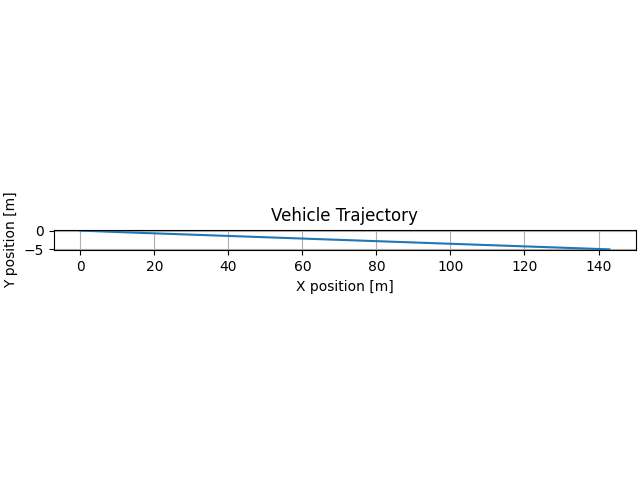

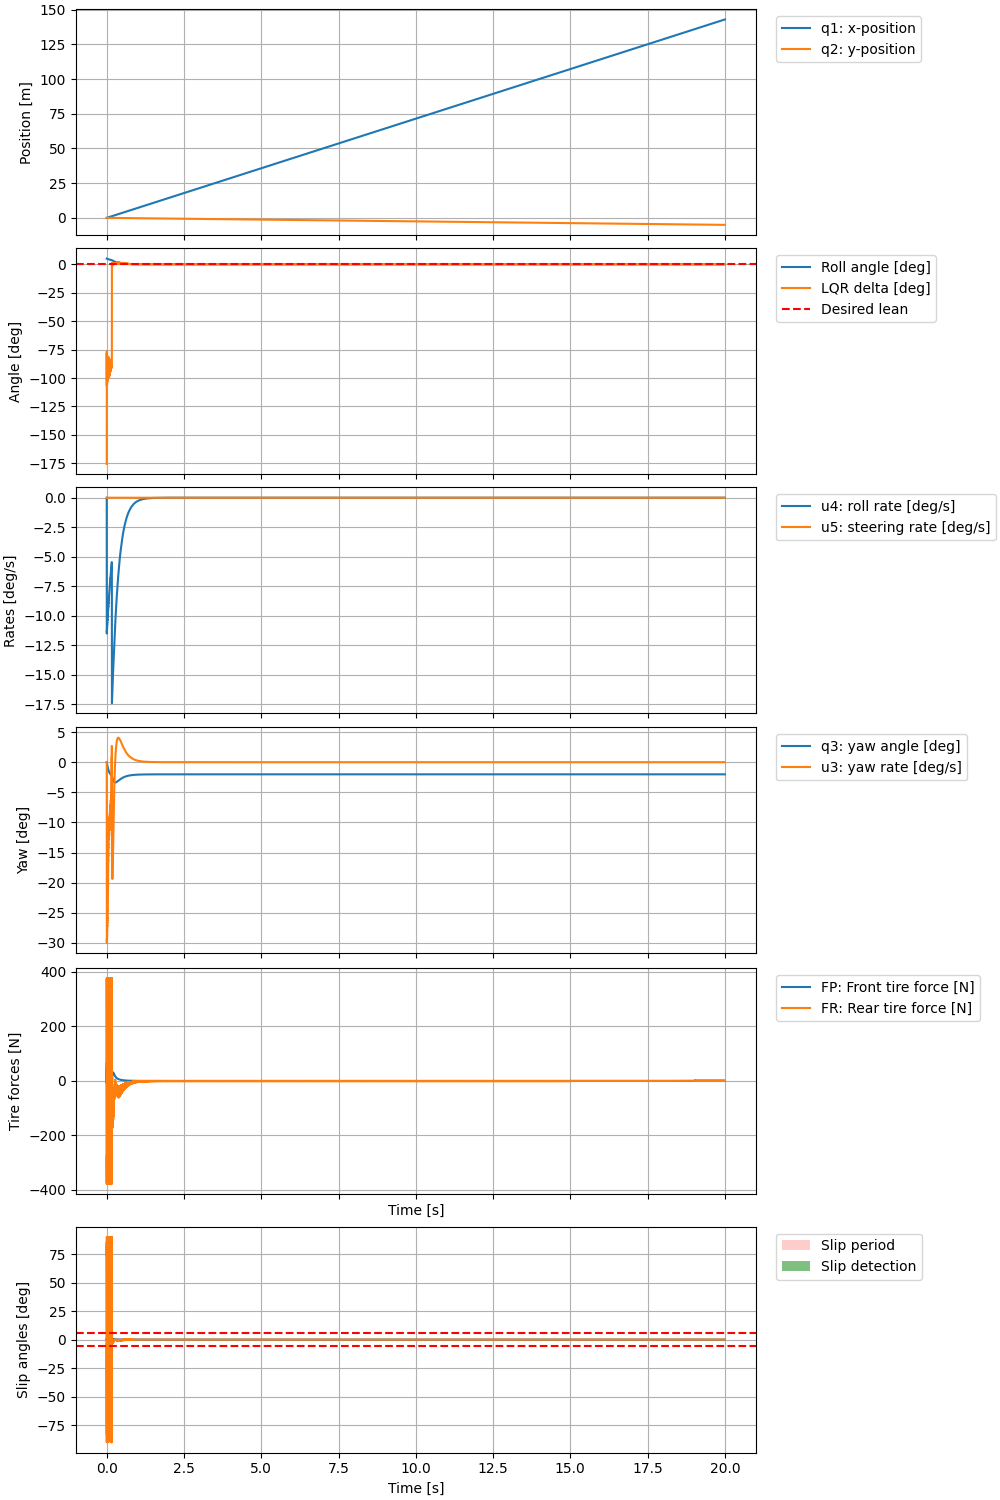

In [96]:
########### post process ###########
qs = solution.y[0:4]
us = solution.y[4:8]

# Convert stored values to numpy arrays
alphaP_arr = np.array(alphaP_history).squeeze()
alphaR_arr = np.array(alphaR_history).squeeze()
FyP_arr = np.array(FyP_history).squeeze()
FyR_arr = np.array(FyR_history).squeeze()

# Create time array for stored values (from the solver's internal steps)
internal_times = np.array(time_history)  # You'll need to store time in rhs()

# First, extract delta values from control_history
delta_history = [cmd[0] for cmd in control_history]  # Get first element of each control output

# Convert stored values to numpy arrays
delta_arr = np.array(delta_history).squeeze()
time_arr = np.array(control_times)

# Create interpolation function for delta
interp_delta = interp1d(time_arr, delta_arr, bounds_error=False, fill_value="extrapolate")
delta_plot = interp_delta(solution.t)

# Create interpolation functions
from scipy.interpolate import interp1d
interp_alphaP = interp1d(internal_times, alphaP_arr, bounds_error=False, fill_value="extrapolate")
interp_alphaR = interp1d(internal_times, alphaR_arr, bounds_error=False, fill_value="extrapolate")
interp_FyP = interp1d(internal_times, FyP_arr, bounds_error=False, fill_value="extrapolate")
interp_FyR = interp1d(internal_times, FyR_arr, bounds_error=False, fill_value="extrapolate")

# Get values at solution time points
alphaP_plot = interp_alphaP(solution.t)
alphaR_plot = interp_alphaR(solution.t)
FyP_plot = interp_FyP(solution.t)
FyR_plot = interp_FyR(solution.t)

# After simulation, check if we have data
if not control_history:
    raise RuntimeError("No control outputs were recorded during simulation")

# Create interpolators
control_arr = np.array(control_history).T
steering_interp = interp1d(control_times, control_arr[0], 
                          bounds_error=False, fill_value="extrapolate")

# Get steering angles at solution time points
steering_angles = steering_interp(solution.t)
steering_rates = np.zeros_like(steering_angles)  # u5 is always 0

################################### Plots #############################################
# Create your plots with constrained layout
fig, axes = plt.subplots(6, 1, sharex=True, layout='constrained', figsize=(10, 15))

# Plot 1: Position states (q1, q2)
axes[0].plot(solution.t, qs[0], label='q1: x-position')
axes[0].plot(solution.t, qs[1], label='q2: y-position')
axes[0].set_ylabel('Position [m]')
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid(True)

# Plot 2: Lean and Control Input
axes[1].plot(solution.t, np.rad2deg(qs[3]), label='Roll angle [deg]')
axes[1].plot(solution.t, np.rad2deg(delta_plot), label='LQR delta [deg]')
axes[1].axhline(theta_des, color='r', linestyle='--', label='Desired lean')
axes[1].set_ylabel('Angle [deg]')
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].grid(True)

# Plot 3: Lean rate and Steering rate (u4, u5)
axes[2].plot(solution.t, np.rad2deg(us[3]), label='u4: roll rate [deg/s]')
axes[2].plot(solution.t, np.rad2deg(steering_rates), label='u5: steering rate [deg/s]')
axes[2].set_ylabel('Rates [deg/s]')
axes[2].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[2].grid(True)

# Plot 4: Yaw states (q3, u3)
axes[3].plot(solution.t, np.rad2deg(qs[2]), label='q3: yaw angle [deg]')
axes[3].plot(solution.t, np.rad2deg(us[2]), label='u3: yaw rate [deg/s]')
axes[3].set_ylabel('Yaw [deg]')
axes[3].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[3].grid(True)

# Plot 5: Tire forces (Fy)
axes[4].plot(solution.t, FyP_plot, label='FP: Front tire force [N]')
axes[4].plot(solution.t, FyR_plot, label='FR: Rear tire force [N]')
axes[4].set_ylabel('Tire forces [N]')
axes[4].set_xlabel('Time [s]')
axes[4].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[4].grid(True)


# Plot 6: Slip Angles
axes[5].plot(solution.t, np.rad2deg(alphaP_plot), label='αP: Front slip angle [deg]')
axes[5].plot(solution.t, np.rad2deg(alphaR_plot), label='αR: Rear slip angle [deg]')
axes[5].axhline(6, color='r', linestyle='--', label='Max slip (6°)')
axes[5].axhline(-6, color='r', linestyle='--')

# Highlight actual detected slip periods
if len(monitor['active_slip_periods']) > 0:
    for start, end in monitor['active_slip_periods']:
        axes[5].axvspan(start, end, color='red', alpha=0.2, label='Slip detected' if start == monitor['active_slip_periods'][0][0] else "")

# Also mark the specific moments when slips were first detected
if len(monitor['slip_start_times']) > 0:
    for t in monitor['slip_start_times']:
        axes[5].axvline(t, color='green', linestyle=':', alpha=0.5, label='Slip detected' if t == monitor['slip_start_times'][0] else "")

axes[5].set_ylabel('Slip angles [deg]')
axes[5].set_xlabel('Time [s]')

# Create custom legend entries
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.2, label='Slip period'),
    Patch(facecolor='green', alpha=0.5, label='Slip detection', linestyle=':', linewidth=1)
]
axes[5].legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')
axes[5].grid(True)



# Adjust layout
plt.subplots_adjust(right=0.8)

# Trajectory plot (unchanged)
fig2, ax = plt.subplots(layout='constrained')
ax.plot(qs[0], qs[1])
ax.set_aspect('equal')
ax.set_xlabel('X position [m]')
ax.set_ylabel('Y position [m]')
ax.set_title('Vehicle Trajectory')
ax.grid(True)

plt.show()